## Node2vec

In [6]:
import numpy as np 
import matplotlib.pyplot as plt

import pickle

In [7]:
from sklearn.decomposition import PCA

In [8]:
import sys

sys.path.append("./node2vec/src/")

In [9]:
import utils.utils as u

In [10]:
import main as n2v
import node2vec as n2v_src
import networkx as nx

In [11]:
from importlib import reload
n2v = reload(n2v)
n2v_src = reload(n2v_src)

In [9]:
gr0 = np.load("../data/graphs/SlO_22.npy")#[:34,:34]
nd = pickle.load(open("../data/dicts/SlO_counts_22", 'rb'))
sp_to_n = pickle.load(open("../data/dicts/SlO_sp_to_n_22", 'rb'))

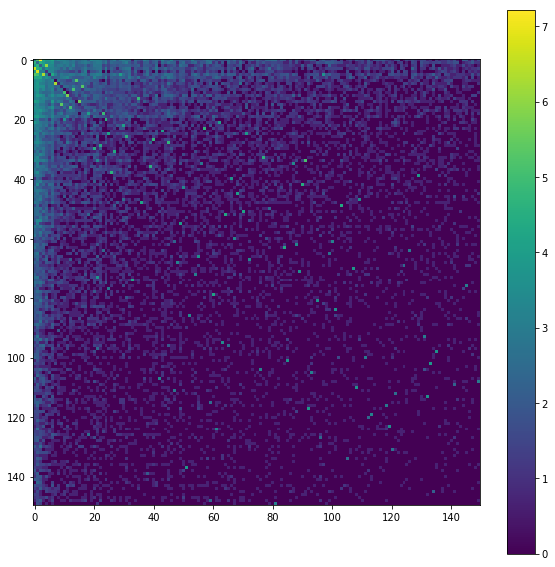

In [10]:
u.plot_gr(gr0[:150, :150], log = 1)

In [11]:
good_keys = []
for k in nd.keys():
    if nd[k] > 5:
        good_keys.append(k)

In [12]:
mask = np.zeros(gr0.shape[0]).astype(bool)
for k in good_keys:
    mask[sp_to_n[k]] = True

In [13]:
gr = gr0[mask][:, mask]

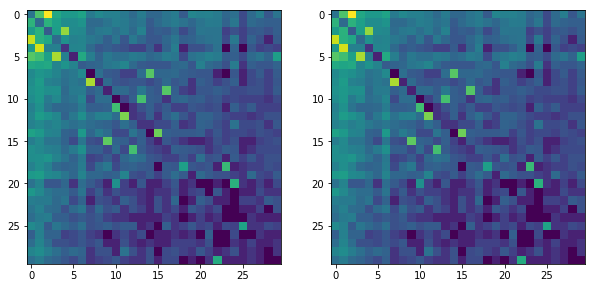

In [15]:
u.plot_grs(gr0[:30, :30], gr[:30, :30], log=1)

In [16]:
gr[(gr.sum(1) == 0)] = 1

In [44]:
gr.shape

(746, 746)

In [45]:
np.save("../data/graphs/SlO_22_cut_at_10", gr)

### Helpers

In [487]:
def normalize(X):
    sums = X.sum(1)
    sums[sums == 0] = 1
    D = np.diag(1 / np.sqrt(sums))
    
    return np.dot(np.dot(D, X), D)

In [488]:
def normalize_arr(X):
    X_n = np.zeros_like(X)
    for i, x in enumerate(X):
        X_n[i] = normalize(x)
    return X_n

In [489]:
def create_powers(X, max_power=5):
    X_p = np.zeros((X.shape[0], max_power, X.shape[1], X.shape[2]))
    for i, x in enumerate(X):
        X_p[i, 0] = x
        for p in range(2, max_power + 1):
            X_p[i, p - 1] = np.dot(X_p[i, p - 2], x)
            
    return X_p

## ES 3

In [490]:
population_as_list = [[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(1)] + \
               [[4, 2, 5, 7, 11] for i in range(1)] + \
               [[4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34]] + \
               [[1, 20, 22, 23, 21, 29]]

In [629]:
gr = np.load("../data/graphs/ES3_22.npy")[:35, :35]

In [630]:
gr_n = normalize(gr)

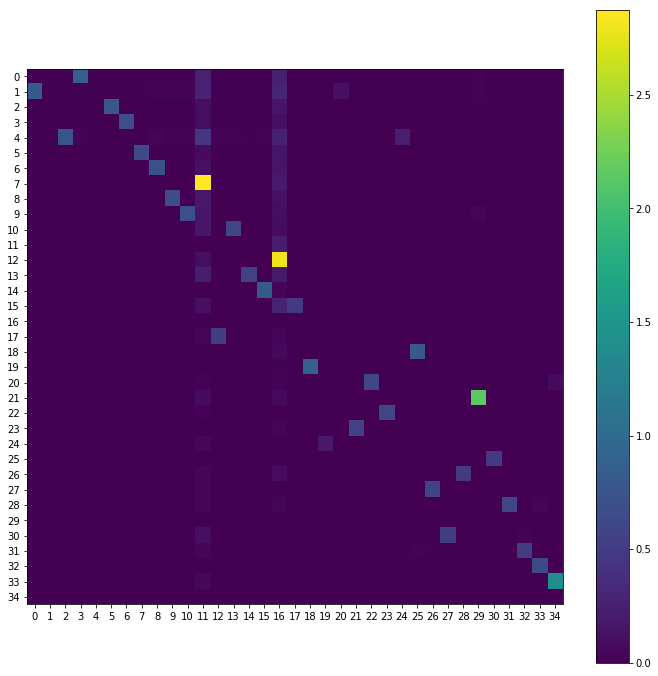

In [631]:
u.plot_gr(gr_n, log = 1, s = 12, all_ticks=1)

In [49]:
def plot_embs_space(emb, p_as_list, special_cases):
    plt.scatter(emb[:,0], emb[:, 1])

    plt.scatter(emb[p_as_list[0],0], emb[p_as_list[0], 1], c = 'r')
    plt.scatter(emb[1,0], emb[1, 1], marker = 'x', s= 200, c = 'r')


    plt.scatter(emb[p_as_list[3],0], emb[p_as_list[3], 1], c = 'g')



    plt.scatter(emb[p_as_list[1],0], emb[p_as_list[1], 1], c = 'y')
    plt.scatter(emb[4,0], emb[4, 1], marker = 'x', s= 200, c = 'y')


    plt.scatter(emb[p_as_list[2],0], emb[p_as_list[2], 1], c = 'black')

In [423]:
def random_walks(gr, walks_n, max_len):
    sums = gr.sum(1)
    mask = sums != 0
    gr_n = gr / sums.reshape(-1, 1)
      
    walks = []
    
    for i in range(walks_n * gr.shape[0]):
        #curr = np.random.randint(0, gr_n.shape[0])
        curr = i % gr.shape[0]
        walk = []
        stop = False
        while not stop:
            walk.append(curr)
            if gr[curr].sum() == 0 or len(walk) == max_len:
                stop = True
            else:
                curr = np.random.choice(np.arange(gr.shape[0]), 1, p = gr_n[curr])[0]
                max_tries = 0
                while curr in walk and max_tries < 20:
                    curr = np.random.choice(np.arange(gr.shape[0]), 1, p = gr_n[curr])[0]
                    max_tries += 1
        
        walks.append(walk)
    
    return walks

In [13]:
def gr_to_nxGr(graph):
    nxG = nx.DiGraph()
    for i in range(graph.shape[0]):
        for j in range(graph.shape[1]):
            nxG.add_edge(i, j, weight = graph[i,j])
    return nxG

In [533]:
def gr_to_emb(graph, walks_n, l, emb_size = 20):
    spacers_num = graph.shape[0]
    
#     print("ngx")
#     nx_gr = gr_to_nxGr(graph)
#     G = n2v_src.Graph(nx_gr, 1, 0.5, 0.5)
#     G.preprocess_transition_probs()
#     print('walks')
#     walks = G.simulate_walks(walks_n, l)

    walks = random_walks(graph, walks_n, l)
    print('train')
    model = n2v.learn_embeddings(walks, emb_size, 1, 4, 200)
    
    print("PCA")
    E = np.zeros((spacers_num, emb_size))
    for i in range(spacers_num):
        E[i] = model.wv.word_vec(str(i))
    pca = PCA(n_components=emb_size)
    
    return pca.fit_transform(E), model, walks

In [422]:
emb, model, walks = gr_to_emb(gr, 100, 20)

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


train
PCA


In [534]:
log_emb, log_model, walks = gr_to_emb(np.log(gr_n + 1), 100, 10)

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


train
PCA


In [56]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [1, 20, 22, 23, 21, 29]]

In [405]:
walks

[[0, 3, 6, 8, 16, 9, 10, 13, 14, 15, 7, 17, 12, 11, 22],
 [1, 9, 10, 13, 14, 15, 7, 11, 6, 8, 30, 27, 26, 28, 31],
 [2, 11, 0, 7, 16, 10, 13, 14, 15, 5, 17, 12, 4, 3, 6],
 [3, 6, 8, 16, 9, 10, 13, 14, 15, 1, 0, 21, 11, 4, 2],
 [4, 2, 5, 7, 11, 0, 3, 6, 8, 9, 14, 15, 17, 12, 16],
 [5, 7, 11, 10, 13, 14, 15, 17, 12, 16, 8, 9, 6, 3, 0],
 [6, 8, 9, 10, 13, 14, 15, 17, 12, 16, 0, 3, 1, 4, 2],
 [7, 11, 16, 9, 10, 13, 14, 15, 17, 12, 3, 6, 8, 4, 2],
 [8, 9, 10, 6, 4, 2, 5, 7, 11, 14, 15, 13, 17, 12, 16],
 [9, 10, 1, 20, 22, 11, 2, 5, 7, 16, 3, 6, 8, 13, 14],
 [10, 13, 14, 15, 17, 0, 3, 6, 8, 9, 12, 16, 11, 1, 2],
 [11, 0, 3, 6, 8, 9, 10, 13, 7, 14, 16, 20, 22, 15, 1],
 [12, 16, 8, 9, 10, 13, 14, 15, 17, 0, 3, 6, 1, 4, 2],
 [13, 14, 15, 17, 9, 10, 16, 3, 6, 8, 11, 0, 12, 28, 31],
 [14, 15, 6, 8, 9, 10, 13, 17, 12, 16, 11, 2, 5, 4, 1],
 [15, 17, 12, 16, 6, 8, 7, 11, 2, 5, 0, 3, 4, 1, 9],
 [16, 8, 9, 10, 13, 17, 12, 14, 15, 0, 7, 11, 2, 5, 1],
 [17, 12, 16, 0, 3, 6, 8, 9, 10, 13, 14, 15, 2, 5, 7

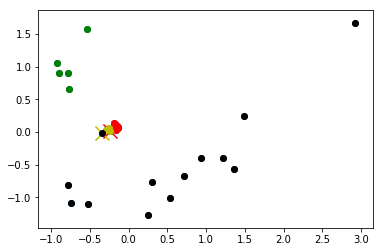

In [484]:
plot_embs_space(emb, population_as_list, None)

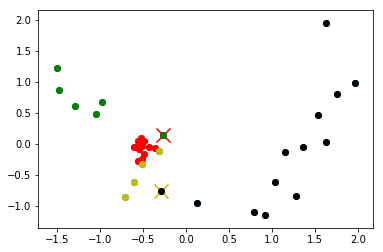

In [535]:
plot_embs_space(log_emb, population_as_list, None)

In [426]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [1, 20, 22, 23, 21, 29]]

In [537]:
model.most_similar(positive='4')

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('11', 0.9110259413719177),
 ('1', 0.7139437794685364),
 ('16', 0.6140578985214233),
 ('3', 0.47817158699035645),
 ('18', 0.4085416793823242),
 ('8', 0.3459894359111786),
 ('10', 0.3310788571834564),
 ('24', 0.32903656363487244),
 ('15', 0.31040915846824646),
 ('22', 0.30940553545951843)]

### Inv walks

In [407]:
from nltk import ngrams

In [411]:
trigrams = {}

In [412]:
for w in walks:
    for x in  ngrams(w, 3):
        if x in trigrams:
            trigrams[x] += 1
        else:
            trigrams[x] = 1

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: generator 'ngrams' raised StopIteration
  


In [414]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [1, 20, 22, 23, 21, 29]]

In [415]:
trigrams[(1, 20, 22)]

33

In [502]:
for i in range(35):
    for j in range(35):
        if (1,i,j) in trigrams:
            pass
            #print((1,i,j), trigrams[(1,i,j)])

## Model Edge pred

In [89]:
import h_module.hamiltonian_path as hp

In [91]:
c = {}
hp.next_edge(gr,c)

10

In [94]:
def get_weights(gr,chain):
    w = []
    for x, y in zip(chain, chain[1:]):
        w.append(gr[x][y])
    return w

In [108]:
def get_positive_edges(chain, weights, trsh):
    good_edges = []
    chains = []
    
    curr_chain = []
    for x,y,w in zip(chain, chain[1:], weights):
        if w >= trsh:
            good_edges.append((x, y))
            if len(curr_chain) == 0:
                curr_chain.append(x)
            curr_chain.append(y)
        else:
            chains.append(curr_chain)
            curr_chain = []
    if not curr_chain in chains:
        chains.append(curr_chain)
        
    return good_edges, chains

In [109]:
c[0]

[4, 2, 5, 7, 11, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34, 20, 22, 23, 21, 29, 1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16]

In [110]:
w = get_weights(gr, c[0].chain)

In [113]:
positive_edges, positive_chains = get_positive_edges(c[0].chain, w, 5)

In [384]:
def generate_negative_edge(positive_edges, positive_chains):
    edges = []
    
    for edge in positive_edges:
        edges.append(edge[::-1])
        
    for c in positive_chains:
        for i, v in enumerate(c):
            for j in range(0, i - 1):
                edges.append((v, c[j]))
                edges.append((c[j], v))

    return edges

In [385]:
negative_edges = generate_negative_edge(positive_edges, positive_chains)

In [388]:
(5,2) in negative_edges

True

In [287]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [1, 20, 22, 23, 21, 29]]

In [389]:
def generate_dataset(emb, positive_edges, negative_edges):
    data = np.zeros((len(positive_edges) + len(negative_edges), emb.shape[1] * 2))
    y = np.zeros(data.shape[0])
    
    for i,edge in enumerate(positive_edges):
        data[i] = np.hstack((emb[edge[0]], emb[edge[1]]))
        y[i] = 1
    
    shift = len(positive_edges)
    for i,edge in enumerate(negative_edges):
        data[i + shift] = np.hstack((emb[edge[0]], emb[edge[1]]))
        y[i + shift] = 0
    
    return data, y
    

In [538]:
X, y = generate_dataset(log_emb, positive_edges, negative_edges)

In [504]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [539]:
lr = LogisticRegression(class_weight='balanced')
rf = RandomForestClassifier(100, class_weight='balanced')

In [540]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [541]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [508]:
from tqdm import tqdm_notebook

In [509]:
def range_graph(gr, emb, model):
    scores = np.zeros_like(gr)
    
    for i in tqdm_notebook(range(gr.shape[0])):
        for j in range(gr.shape[1]):
            x = np.hstack((emb[i], emb[j]))
            scores[i,j] = model.predict_proba(x.reshape(1, -1))[0][1]
    return scores

In [542]:
gr_scores = range_graph(gr, log_emb, rf)

A Jupyter Widget

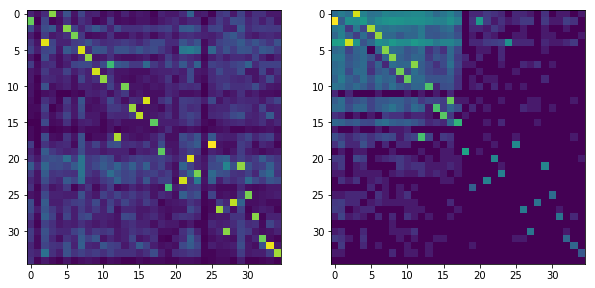

In [543]:
u.plot_grs(gr_scores, np.log(gr + 1))#, mask_graph)

In [597]:
mask_graph = np.ones_like(gr)
for e in negative_edges:
    mask_graph[e[0], e[1]] = 0
for e in positive_edges:
    mask_graph[e[0], e[1]] = 0
mask_graph -= np.diag(np.ones(35))

In [521]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [1, 20, 22, 23, 21, 29]]

In [547]:
gr_scores.argsort(1)[4]

array([24,  1,  4,  5, 25, 15, 20, 19, 10, 11, 33, 14,  0, 12, 16,  9, 13,
        6,  7, 26, 22, 30,  3, 32, 27, 17, 18, 28,  8, 34, 21, 31, 23, 29,
        2])

In [550]:
np.argsort(gr_scores * mask_graph)[4]

array([ 2,  4,  5,  7, 11, 24,  1, 25, 15, 20, 19, 10, 33, 14,  0, 12,  9,
       16,  6, 13, 22, 26, 32, 30,  3, 27, 17, 18, 28,  8, 34, 21, 31, 23,
       29])

In [553]:
(gr_scores * mask_graph)[4]

array([0.11, 0.04, 0.  , 0.15, 0.  , 0.  , 0.13, 0.  , 0.18, 0.12, 0.09,
       0.  , 0.11, 0.13, 0.11, 0.08, 0.12, 0.16, 0.16, 0.09, 0.09, 0.19,
       0.14, 0.19, 0.02, 0.07, 0.14, 0.16, 0.17, 0.21, 0.15, 0.19, 0.15,
       0.11, 0.18])

In [394]:
737 // 35

21

In [395]:
737 % 35

2

In [368]:
gr_scores[32,33]

0.75

In [338]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [1, 20, 22, 23, 21, 29]]

In [355]:
np.argsort(gr_scores[1])[::-1]

array([ 0, 22, 27,  2,  7, 31, 30, 11, 23, 33, 28,  5, 29, 21, 32, 20, 18,
       25, 34, 19,  6, 14, 10, 24, 26,  8,  4,  3, 17, 13, 12, 15, 16,  9,
        1])

In [356]:
gr_scores[1,20]

0.11

# Use Graph convs

In [557]:
from keras.layers import Dense, Embedding

class GraphConvLayer:
    
    def __init__(self, name, window, size):
        self.name = name
        self.window = window
        self.size = size
        
        with tf.variable_scope(name) as scope:
            self.g = tf.get_variable('g',
                                    shape = [size, window],
                                    initializer=None, trainable=True)
            
            self.b = tf.get_variable('b' , shape = [size], initializer=None, trainable=True) 
        self.scope = scope
        
    def __call__(self, inp, a_powers):
        #assert a_powers.shape[0] == self.window
        
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                tm = tf.tensordot(a_powers[:self.window], inp, axes = [[2], [0]])
                tm_sum = tf.reduce_sum(tm, 2)

                out = tf.tensordot(tm_sum, self.g, axes=[[0],[1]]) + self.b
                
        return out                

In [652]:
tf.reset_default_graph()
sess = tf.Session()

In [653]:
inp = tf.placeholder(tf.float32, [None, None])
a_powers = tf.placeholder(tf.float32, [None, None, None])

c1_l = GraphConvLayer('c1', 5, 16)
c1 = c1_l(inp, a_powers)
# c1 = tf.nn.relu(c1)

# c2_l = GraphConvLayer('c2', 3, 8)
# c2 = c2_l(c1, a_powers)
# c2 = tf.nn.relu(c2)


I = tf.get_variable('i', shape = [16, 8])
O = tf.get_variable('o', shape = [16, 8])


out_logit = tf.matmul(tf.matmul(c1, I), tf.transpose(tf.matmul(c1, O)))
out = tf.nn.sigmoid(out_logit)


# c3_l = GraphConvLayer('c3', 5, 16)
# c3 = c3_l(c2, a_powers)
# c3 = tf.nn.relu(c3)

In [654]:
target = tf.placeholder(tf.float32, [None, None])
weights = tf.placeholder(tf.float32, [None, None])

loss = tf.losses.log_loss(out, target, weights = weights)

In [655]:
optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(loss)

sess.run(tf.global_variables_initializer())

In [656]:
mask_graph = np.zeros_like(gr)
for e in negative_edges:
    mask_graph[e[0], e[1]] = 1 
for e in positive_edges:
    mask_graph[e[0], e[1]] = 1 * 10 
#mask_graph -= np.diag(np.ones(35))

In [657]:
gr_target = np.zeros_like(gr)

for e in positive_edges:
    gr_target[e[0], e[1]] = 1

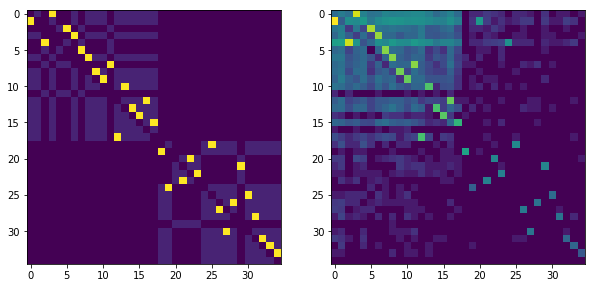

In [658]:
u.plot_grs(mask_graph, np.log(gr + 1))

In [659]:
for i in range(1000):
    l = sess.run([train_step, loss], feed_dict={inp:test_x,
                                                a_powers: gr_powers[0],
                                                target : gr_target,
                                                weights : mask_graph})
    print(l[1])

18.52728
18.46163
18.406822
18.299618
18.22454
18.128216
18.004898
17.89651
17.823212
17.779696
17.742304
17.70121
17.657358
17.617666
17.582825
17.549528
17.515345
17.478348
17.435902
17.383804
17.313892
17.207619
17.079786
16.95266
16.84002
16.749203
16.666683
16.537893
16.311562
15.787526
15.35918
15.261517
15.204974
15.164695
15.132726
15.104367
15.0741415
15.034636
14.997209
14.974362
14.957131
14.942006
14.928154
14.91522
14.902986
14.891304
14.880055
14.869173
14.858586
14.848258
14.83815
14.828232
14.818481
14.808888
14.799431
14.790098
14.780887
14.771784
14.762785
14.753885
14.745078
14.736361
14.7277355
14.7191925
14.710732
14.7023535
14.694055
14.685834
14.677682
14.669609
14.661605
14.653668
14.645797
14.637982
14.630228
14.622523
14.614857
14.607234
14.59963
14.592043
14.584452
14.576836
14.569175
14.561431
14.553556
14.545493
14.53716
14.528434
14.519149
14.509048
14.497657
14.482958
14.4484625
14.399274
14.375862
14.352404
14.325274
14.288303
14.231514
14.14674
14.04594

11.313587
11.313557
11.313528
11.313496
11.313466
11.313437
11.313407
11.313377
11.313349
11.313318
11.313291
11.313261
11.3132305
11.313203
11.313173
11.313145
11.313117
11.313089
11.31306
11.313032
11.3130045
11.312977
11.312948
11.31292
11.312893
11.312866
11.312838
11.31281
11.312784
11.312756
11.31273
11.312702
11.312677
11.312647
11.312621
11.312594
11.312569
11.31254
11.312515
11.3124895
11.312463
11.312437
11.312412
11.312386
11.31236
11.312335
11.312308
11.312284
11.312258
11.312234
11.312207
11.312183
11.312158
11.312133
11.312108
11.312084
11.312059
11.312036
11.31201
11.311987
11.311961
11.311939
11.3119135
11.31189
11.311866
11.311844
11.31182
11.311796
11.311772
11.3117485
11.311726
11.311702
11.311679
11.311656
11.311632
11.31161
11.311587
11.311565
11.3115425
11.31152
11.311498
11.311476
11.311452
11.31143
11.311407
11.311386
11.311362
11.311342
11.311318
11.311297
11.311277
11.3112545
11.311234
11.311212
11.31119
11.311169
11.311147
11.311126
11.311106
11.311085
11.311

In [660]:
pred = sess.run(out, feed_dict={inp:test_x,
                                                a_powers: gr_powers[0],
                                                target : gr_target,
                                                weights : mask_graph})

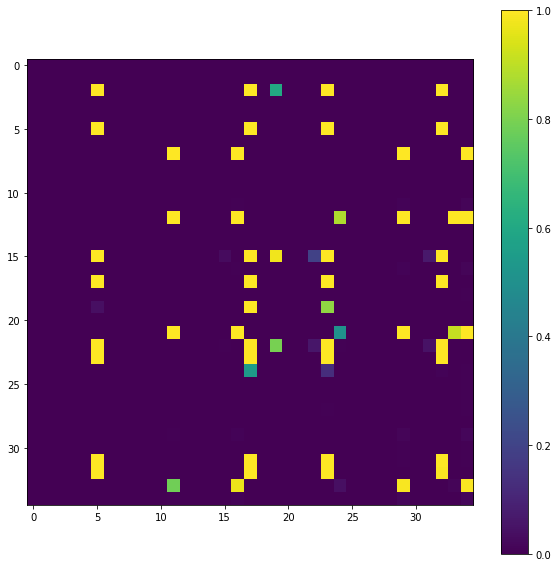

In [661]:
u.plot_gr(pred)

In [604]:
len(negative_edges)

297

In [605]:
len(positive_edges)

31

In [582]:
sess.run(c1, feed_dict={inp : test_x, a_powers : gr_powers[0]}).shape

(35, 32)

In [581]:
test_x = np.diag(np.ones(35))


In [564]:
gr_powers = create_powers(np.expand_dims(gr_n, 0))

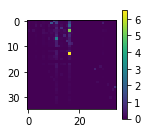

In [571]:
u.plot_gr(gr_powers[0,4], s = 2)

In [ ]:
sess.

## TF EMBS

In [183]:
import tensorflow as tf
import keras

from keras.layers import Embedding, Dense

(195, 8)

In [449]:
VOC_SIZE = 35
EMB_SIZE = 20

In [450]:
tf.reset_default_graph()
sess = tf.Session()

In [451]:
inp = tf.placeholder(tf.int32, [None])

emb_layer = Embedding(VOC_SIZE, EMB_SIZE)
emb_val = emb_layer(inp)

dense_layer = Dense(VOC_SIZE)
out = dense_layer(emb_val)


In [452]:
target = tf.placeholder(tf.float32, [None, VOC_SIZE])

In [453]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=out))

In [454]:
opt = tf.train.AdamOptimizer()
train_step = opt.minimize(loss)

In [455]:
sess.run(tf.global_variables_initializer())

In [456]:
def generate_batch(walks, batch_size, window):
    for i in range(len(walks) // batch_size):
        batch_walks = walks[i * batch_size:(i + 1) * batch_size]
        x = np.zeros(batch_size)
        y = np.zeros((batch_size, VOC_SIZE))
        
        for j, w in enumerate(batch_walks):
            pos = np.random.randint(0, len(w))
            x[j] = w[pos]
            for k in range(window):
                if k + pos + 1 < len(w):
                    y[j, w[k + pos + 1]] = 1
        
        
        yield x.astype(int) , y

In [446]:
def generate_batch(walks, batch_size, window):
    for i in range(len(walks) // batch_size):
        x = np.ones(10)
        y = np.zeros((10, VOC_SIZE))
        y[:,3] = 1
        
        
        yield x.astype(int) , y

In [447]:
x

(5, 7, 0)

In [457]:
for ep in range(1000):
    ep_loss = 0
    for x, y in generate_batch(walks, 20, 3):
        curr_loss = sess.run([train_step, loss], feed_dict={inp : x, target : y})
        ep_loss += curr_loss[1]
    
    print(ep_loss)

102.829320281744
55.55516944825649
43.82180081307888
41.48860560357571
40.694438859820366
39.48160842061043
38.078424870967865
36.7532964348793
35.86649268865585
34.830713510513306
34.10818015038967
34.25364647805691
33.406434282660484
32.41593873500824
32.572093456983566
32.27253770828247
31.834705144166946
31.67475888133049
31.750346548855305
31.490632116794586
30.963456958532333
31.3820708245039
30.619276247918606
30.596731424331665
30.408971905708313
30.044086031615734
30.677926547825336
30.69166788458824
30.809073247015476
30.885317377746105
30.579671196639538
30.343060210347176
30.621735006570816
30.3134046792984
29.823053419589996
30.392858311533928
30.042697079479694
29.90308140218258
29.982372149825096
30.023119427263737
30.133633941411972
30.022570051252842
29.978671796619892
30.46056218445301
30.07523190230131
29.73524648696184
30.162015788257122
29.621989741921425
29.70803539454937
29.82572489231825
29.941090688109398


KeyboardInterrupt: 

In [458]:
my_embs = sess.run(emb_layer.weights)[0]

In [459]:
pca = PCA(10)
my_embs_pca = pca.fit_transform(my_embs)

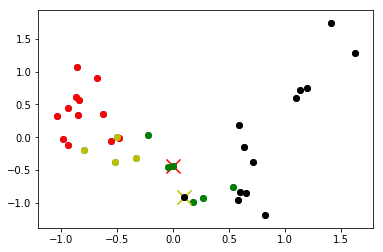

In [460]:
plot_embs_space(my_embs_pca, population_as_list, None)

# Clustering

In [437]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture

In [479]:
km = KMeans(2)

In [480]:
preds = km.fit_predict(emb[:,:])

In [481]:
preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [472]:
sums = gr.sum(1).reshape(-1,1)
sums[sums == 0] = 1

In [473]:
preds = km.fit_predict(gr / sums)

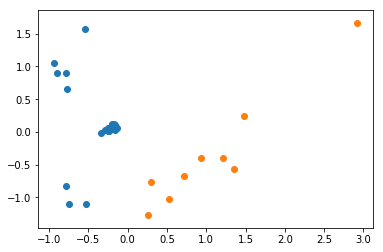

In [482]:
plt.scatter(emb[preds == 1,0], emb[preds == 1, 1])
plt.scatter(emb[preds == 0,0], emb[preds == 0, 1])
plt.scatter(emb[preds == 2,0], emb[preds == 2, 1])
plt.scatter(emb[preds == 3,0], emb[preds == 3, 1])

In [465]:
gm = GaussianMixture(4)

In [466]:
gm.fit(emb[:])
preds = gm.predict(emb[:])

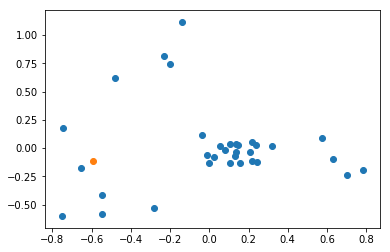

In [136]:
plt.scatter(log_emb[preds == 1,0], log_emb[preds == 1, 1])
plt.scatter(log_emb[preds == 0,0], log_emb[preds == 0, 1])

In [53]:
walks

[[0, 3, 6, 15, 8, 9, 10, 13, 14, 15],
 [1, 0, 3, 6, 8, 9, 10, 13, 4, 2],
 [2, 5, 7, 10, 9, 10, 13, 14, 15, 17],
 [3, 6, 8, 9, 10, 13, 14, 15, 17, 12],
 [4, 0, 3, 6, 8, 9, 7, 11, 16, 8],
 [5, 7, 11, 14, 15, 17, 12, 16, 10, 13],
 [6, 1, 0, 3, 6, 8, 9, 10, 11, 2],
 [7, 1, 0, 3, 6, 8, 9, 10, 13, 14],
 [8, 9, 6, 8, 9, 10, 16, 8, 9, 10],
 [9, 10, 13, 14, 15, 17, 21, 29, 8, 9],
 [10, 13, 14, 15, 3, 6, 8, 9, 6, 8],
 [11, 12, 16, 8, 9, 10, 4, 2, 12, 16],
 [12, 7, 11, 12, 16, 3, 14, 15, 7, 11],
 [13, 14, 15, 17, 12, 16, 6, 8, 9, 3],
 [14, 15, 17, 25, 30, 0, 3, 6, 8, 15],
 [15, 17, 12, 16, 3, 6, 1, 0, 3, 6],
 [16, 10, 13, 14, 15, 17, 12, 16, 10, 8],
 [17, 12, 16, 9, 10, 13, 1, 0, 3, 6],
 [18, 25, 1, 0, 3, 6, 8, 9, 17, 12],
 [19, 18, 25, 7, 11, 2, 5, 7, 11, 0],
 [20, 3, 6, 8, 10, 10, 13, 14, 15, 17],
 [21, 29, 8, 0, 3, 6, 8, 9, 12, 16],
 [22, 23, 21, 29, 8, 9, 10, 13, 14, 15],
 [23, 21, 29, 8, 9, 7, 11, 14, 15, 3],
 [24, 19, 18, 25, 0, 3, 6, 8, 9, 10],
 [25, 30, 27, 26, 16, 9, 12, 16, 0, 3],
 [26,

In [66]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [1, 20, 22, 23, 21, 29]]

In [88]:
model.most_similar(positive='1')

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('8', 0.603278398513794),
 ('3', 0.5847119688987732),
 ('30', 0.4833739399909973),
 ('6', 0.4828222692012787),
 ('22', 0.437547504901886),
 ('9', 0.4323849678039551),
 ('0', 0.3893508315086365),
 ('19', 0.3823843002319336),
 ('4', 0.3571333885192871),
 ('25', 0.3315662741661072)]

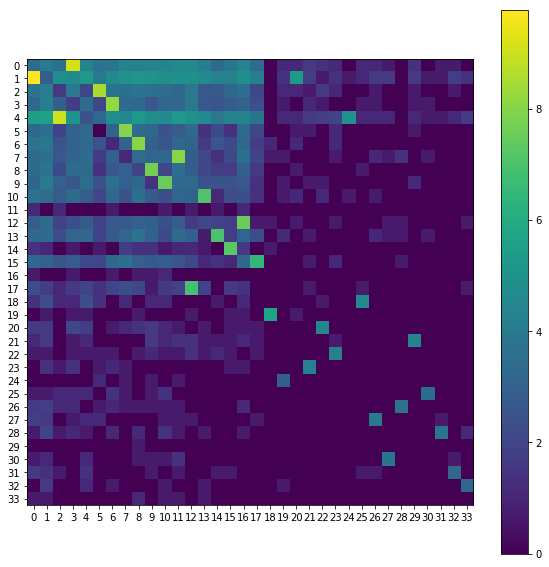

In [143]:
u.plot_gr(gr, log =1, all_ticks=1)

In [117]:
walks

[[17, 12, 16, 9, 10, 1, 0, 4, 2, 5, 0, 3, 6],
 [55],
 [58],
 [19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [6, 8, 8, 9, 3, 6, 8, 9, 10, 13, 14, 15, 17],
 [43],
 [4, 2, 5, 12, 16, 10, 8, 9, 10, 13, 14, 15, 17],
 [50],
 [65],
 [51],
 [62],
 [0, 9, 10, 1, 0, 3, 6, 8, 9, 10, 6, 8, 7],
 [9, 10, 13, 4, 2, 5, 7, 11, 2, 5, 7, 11, 16],
 [14, 15, 17, 12, 16, 6, 8, 9, 10, 13, 14, 15, 17],
 [15, 17, 12, 16, 6, 12, 16, 0, 3, 13, 14, 15, 6],
 [2, 5, 7, 11, 6, 8, 9, 10, 13, 14, 15, 17, 12],
 [61],
 [31, 0, 3, 6, 8, 9, 10, 13, 1, 0, 10, 13, 14],
 [66],
 [67],
 [8, 9, 10, 13, 4, 2, 5, 7, 11, 2, 5, 7, 11],
 [39],
 [71],
 [41],
 [20, 10, 13, 14, 15, 17, 4, 2, 5, 7, 11, 2, 5],
 [49],
 [37],
 [5, 7, 11, 2, 5, 7, 11, 16, 8, 9, 10, 13, 9],
 [40],
 [63],
 [13, 14, 15, 0, 3, 6, 8, 9, 10, 11, 16, 0, 3],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [22, 23, 21, 16, 9, 10, 3, 6, 8, 9, 10, 13, 14],
 [64],
 [38],
 [32, 33, 34],
 [42],
 [57],
 [27, 26, 28, 31, 1, 0, 3, 6, 8, 9, 10, 13, 14],
 [60],
 [54],
 [69]